In [22]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [23]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [24]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

# Load Tracks

In [25]:
# with open(save_dir + '/lin.pkl', 'rb') as f:
#     tracks_obj = pickle.load(f)
with open(save_dir + '/lin.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)
# with open(save_dir + 'base/20051001_20060501.pkl', 'rb') as f:
#     tracks_obj = pickle.load(f)

In [26]:
tracks_obj.params['DT'] = 10
tracks_obj.params['CLASS_THRESH'] = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}
tracks_obj.params['EXCL_THRESH'] = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes
tracks_obj = tint.objects.get_system_tracks(tracks_obj)
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

Calculating system tracks.


In [27]:
# dates = np.arange(
#     np.datetime64('2005-10-01 00:00'), 
#     np.datetime64('2006-05-01 00:00'),
#     np.timedelta64(10, 'm'))

# filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
#     dates, base_dir=base_dir)

# micro_physics = 'cpol'

b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [7]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()
scans = included.loc[:, slice(start_time, end_time), :]
scans = sorted(np.unique(scans.index.get_level_values(0).values))

In [58]:
included

scan   time                 uid 
394    2005-11-12 18:30:00  29      True
395    2005-11-12 18:40:00  29      True
396    2005-11-12 18:50:00  29      True
397    2005-11-12 19:00:00  29      True
398    2005-11-12 19:10:00  29      True
                                    ... 
23852  2006-04-28 08:30:00  2153    True
23853  2006-04-28 08:40:00  2153    True
23854  2006-04-28 08:50:00  2153    True
23855  2006-04-28 09:00:00  2153    True
23856  2006-04-28 09:10:00  2153    True
Length: 1025, dtype: object

In [57]:
len(np.unique(included.index.get_level_values('uid').values))

131

In [28]:
micro_physics = 'lin'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

Gathering files.


In [29]:
filenames

["/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:00:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:10:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:20:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:30:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:40:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:50:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:00:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:10:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:20:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/ca

In [12]:
filenames[59]

"/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T09:50:00.nc"

In [20]:
tracks_obj.tracks.iloc[0]

center                                                    [5.0, 86.0]
com_x                                                         68031.0
com_y                                                       -130759.4
grid_x                                                   70614.051819
grid_y                                                 -127370.892763
proj_area                                                       912.5
lon                                                          131.6981
lat                                                         -13.38005
field_max                                                       56.05
max_height                                                        3.0
volume                                                         456.25
touch_border                                                        8
semi_major                                                  23.037842
semi_minor                                                  16.138948
orientation         

Generating figure for 2006-02-09T09:50.


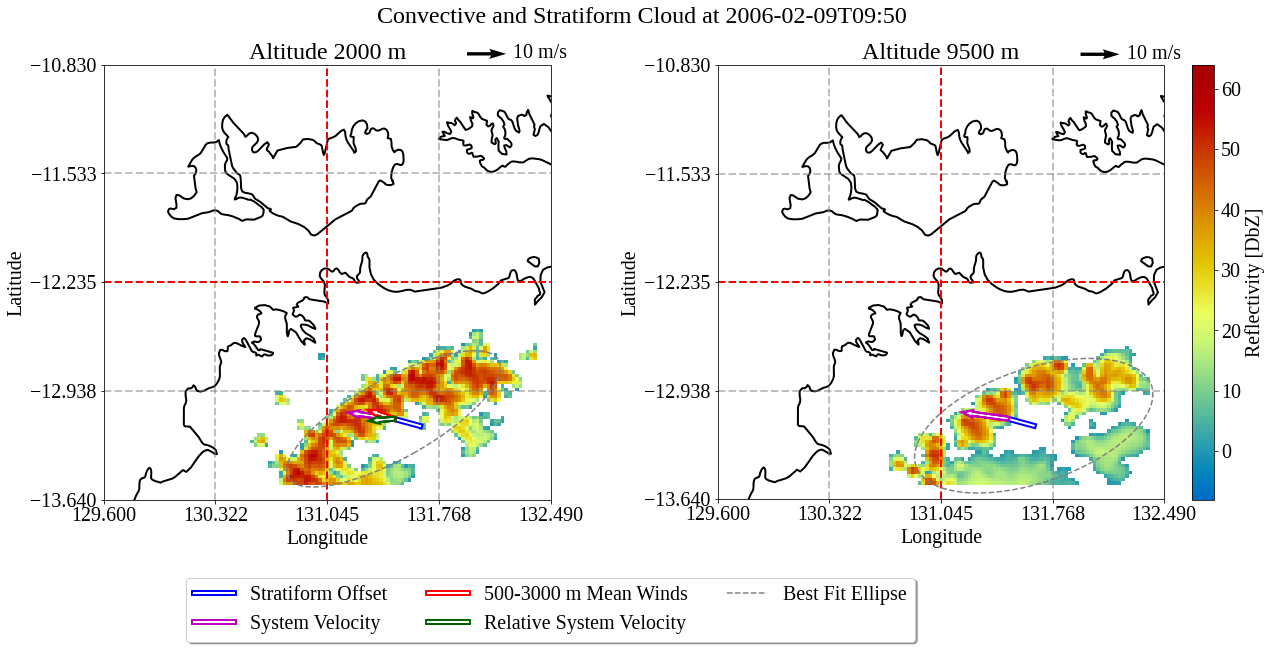

In [54]:
filename = filenames[59]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': None,
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': False, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=2000, alt2=9500)
plt.savefig(
    fig_dir + '/WRF_example_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [13]:
grid.__dict__

{'time': {'long_name': 'Time of grid',
  'units': 'seconds since  2005-12-06T05:10:15Z',
  'standard_name': 'time',
  'calendar': 'gregorian',
  'data': masked_array(data=[0.],
               mask=False,
         fill_value=1e+20,
              dtype=float32)},
 'fields': {'reflectivity': {'_FillValue': -9999.0,
   'long_name': 'Reflectivity',
   'units': 'dBZ',
   'least_significant_digit': 2,
   'standard_name': 'equivalent_reflectivity_factor',
   'coordinates': 'elevation azimuth range',
   'coverage_content_type': 'physicalMeasurement',
   'data': masked_array(
     data=[[[--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --],
            ...,
            [--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --]],
   
           [[--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --],
            [--, --, --, ..., --, --, --],
            ...,
 

In [48]:
np.where(np.array(scans) == 3837)

(array([212]),)

In [50]:
for s in scans[212:214]:
    filename = filenames[s]
    grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

    current_time = str(datetime.datetime.now())[0:-7]
    current_time = current_time.replace(" ", "_").replace(":", "_")
    current_time = current_time.replace("-", "")

    params = {
        'uid_ind': None, 'line_coords': False, 'center_cell': False,
        'cell_ind': 10, 'winds': False, 'winds_fn': filename,
        'crosshair': True, 'fontsize': 18, 'colorbar_flag': True,
        'leg_loc': 2, 'label_type': 'velocities',
        'system_winds': ['shift', 'ambient_mean', 'relative'],
        'boundary': True}

    tint.visualisation.figures.two_level(
        tracks_obj, grid, params=params, alt1=2000)
    plt.savefig(
    fig_dir + '/FFLS_animation/{}.png'.format(s), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
#     plt.show()
    plt.close('all')

Generating figure for 2005-12-07T10:50.
Generating figure for 2005-12-07T11:00.


In [16]:
tracks_obj.system_tracks[['sys_rel_tilt_dir', 'sys_rel_tilt_dir_alt']]

,,,sys_rel_tilt_dir,sys_rel_tilt_dir_alt
scan,time,uid,,
48,2005-11-10 08:10:00,0,-138.098,-138.098
49,2005-11-10 08:20:00,0,-157.360,-157.360
50,2005-11-10 08:30:00,0,179.245,179.245
51,2005-11-10 08:40:00,0,-167.157,-167.157
52,2005-11-10 08:50:00,0,168.426,168.426
...,...,...,...,...
24136,2006-04-30 07:50:00,2167,-139.307,-139.307
24137,2006-04-30 08:00:00,2167,-52.739,-52.739
24138,2006-04-30 08:10:00,2167,-41.918,-41.918


In [15]:
v_w = .9995
v_a = .0015
rho_a = 1.225
rho_w = 1000
k_a = 7.14e-6
k_w = 7.14e-11
1/np.sqrt((v_a*k_a + v_w*k_w)*(v_a*rho_a+v_w*rho_w))

304.6290674994359

In [11]:
tracks_obj.tracks.xs('1', level='uid')

center     com_x     com_y  \
scan time                level                                      
54   2006-02-09 09:00:00 0      [20.0, 107.0]  121658.7  -94912.6   
                         1      [19.0, 108.0]  122722.2  -97103.2   
                         2      [17.0, 108.0]  125652.5 -101498.5   
55   2006-02-09 09:10:00 0       [19.0, 92.0]   79589.1 -102901.3   
                         1       [16.0, 91.0]   79896.4 -105171.6   
...                                       ...       ...       ...   
83   2006-02-09 13:50:00 1       [36.0, 10.0] -124536.4  -53174.9   
                         2       [35.0, 12.0] -120239.1  -54906.5   
84   2006-02-09 14:00:00 0        [44.0, 2.0] -140774.5  -34713.1   
                         1        [36.0, 8.0] -126417.0  -51802.0   
                         2       [36.0, 11.0] -122744.8  -51890.4   

                                       grid_x         grid_y  proj_area  \
scan time                level                                            
54   2006-02-09 09:00:00 0      123773.345947  -91993.408203    1006.25   
                         1      123554.515839  -95404.577255    1750.00   
                         2      128205.051422  -94860.892296    1087.50   
55   2006-02-09 09:10:00 0       81691.837311 -102347.373962    3225.00   
                         1       83160.648346 -104310.083389    5562.50   
...                                       ...            ...        ...   
83   2006-02-09 13:50:00 1     -121585.168839  -56116.294861    1387.50   
                         2     -118441.231251  -58424.539566    1368.75   
84   2006-02-09 14:00:00 0     -140661.962330  -37564.897537     193.75   
                         1     -125231.746435  -53313.322067    1162.50   
                         2     -122113.845348  -54377.107620    1150.00   

                                      lon       lat  field_max  max_height  \
scan time                level                                               
54   2006-02-09 09:00:00 0      132.18802 -13.06028      56.02         3.0   
                         1      132.18614 -13.09097      56.14         7.0   
                         2      132.22905 -13.08589      50.61         9.5   
55   2006-02-09 09:10:00 0      131.79981 -13.15475      56.75         3.0   
                         1      131.81343 -13.17236      57.29         7.0   
...                                   ...       ...        ...         ...   
83   2006-02-09 13:50:00 1      129.92436 -12.73774      53.82         7.0   
                         2      129.95325 -12.75861      46.15         9.5   
84   2006-02-09 14:00:00 0      129.74931 -12.57014      46.72         3.0   
                         1      129.89085 -12.71239      50.65         7.0   
                         2      129.91955 -12.72208      42.36         9.5   

                                ...   v   x_vert_disp   y_vert_disp  \
scan time                level  ...                                   
54   2006-02-09 09:00:00 0      ... NaN           NaN           NaN   
                         1      ... NaN   -218.830109  -3411.169052   
                         2      ... NaN   4650.535583    543.684959   
55   2006-02-09 09:10:00 0      ... NaN           NaN           NaN   
                         1      ... NaN   1468.811035  -1962.709427   
...                             ...  ..           ...           ...   
83   2006-02-09 13:50:00 1      ... NaN  11821.264029 -11489.400864   
                         2      ... NaN   3143.937588  -2308.244705   
84   2006-02-09 14:00:00 0      ... NaN           NaN           NaN   
                         1      ... NaN  15430.215895 -15748.424530   
                         2      ... NaN   3117.901087  -1063.785553   

                                u_ambient_mean  v_ambient_mean  u_relative  \
scan time                level                                               
54   2006-02-09 09:00:00 0            -5.73866         2.25163    -1.5

In [66]:
filename = filenames[59]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

Generating figure for 2006-02-09T09:50.


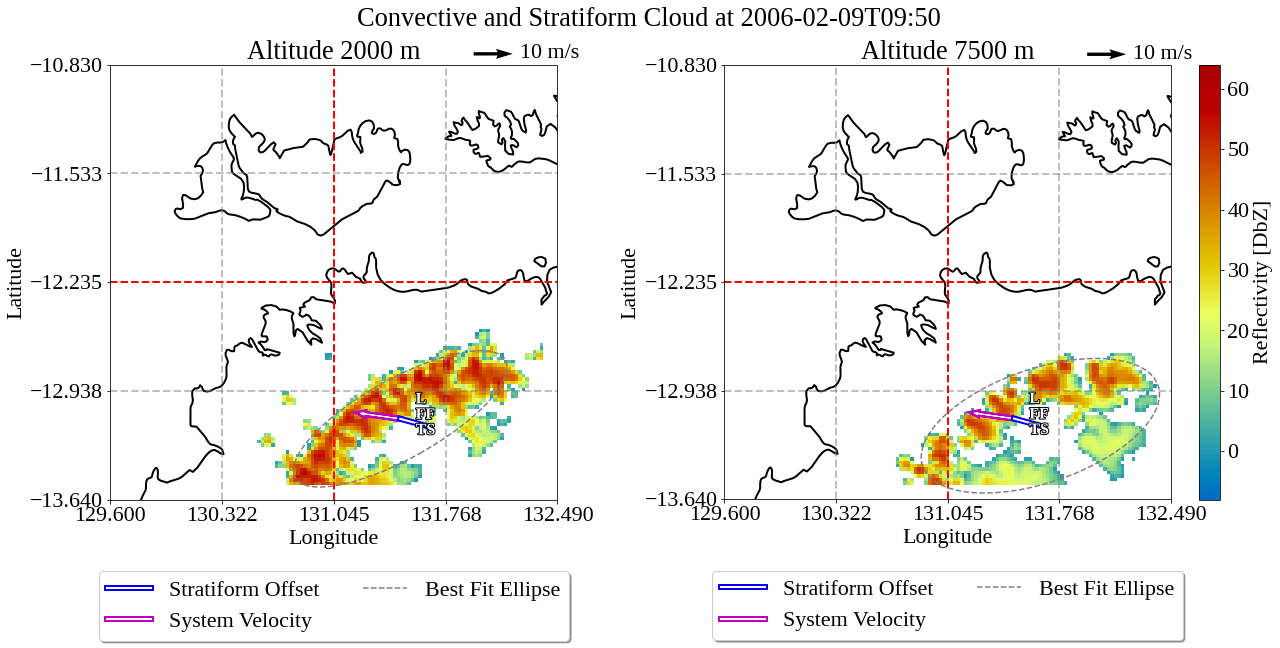

Generating figure for 2006-02-09T09:50.


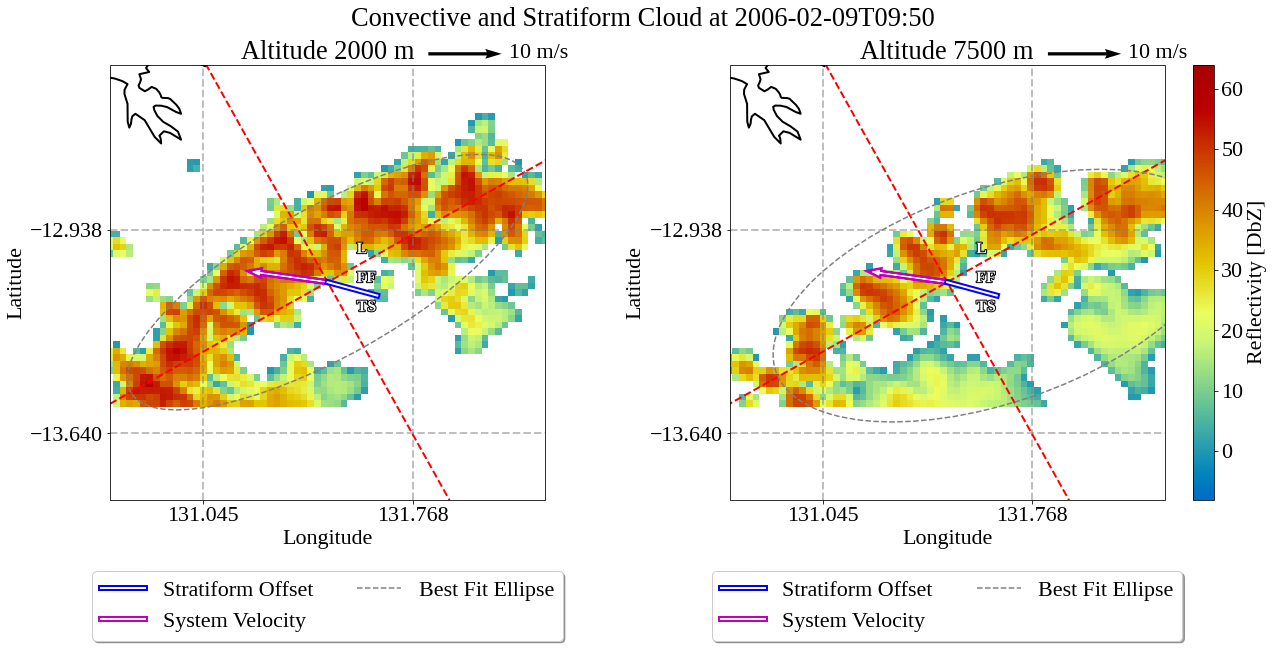

In [62]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 22, 'colorbar_flag': True,
    'leg_loc': 2, 'system_winds': ['shift'],
    'boundary': None, 'exclusions': ['small_area']}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=2000)
plt.savefig(
    fig_dir + 'test.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
plt.show()
plt.close('all')

params = {
    'uid_ind': '1', 'line_coords': True, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 22, 'colorbar_flag': True,
    'leg_loc': 2, 'system_winds': ['shift'],
    'boundary': None, 'exclusions': ['small_area']}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=2000)
plt.savefig(
    fig_dir + 'test2.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
plt.show()
plt.close('all')

In [21]:
list(set(range(1998, 2016)) - {2007, 2008})

[1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [68]:
params = {
        'uid_ind': '1', 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filename, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': False}

grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

tint.visualisation.figures.vertical_cross_section(tracks_obj, grid, params)

Interpolating onto line coordinates.
Calculating horizontal winds in new basis.
Adding reflectivity.
Adding stratiform offset.
Adding winds.
Saving data.


In [185]:
tracks_obj.params['EXCL_THRESH']['SMALL_AREA'] = 500

IndexError: single positional indexer is out-of-bounds

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexing.py(1500)_validate_integer()
   1498         len_axis = len(self.obj._get_axis(axis))
   1499         if key >= len_axis or key < -len_axis:
-> 1500             raise IndexError("single positional indexer is out-of-bounds")
   1501 
   1502     # -------------------------------------------------------------------

ipdb> q


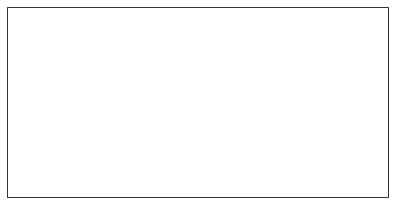

In [64]:
filename=filenames[80]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
uid_ind = '4'

params = {
    'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filename,
    'direction': 'perpendicular', 'crosshair': True, 
    'save_dir': fig_dir, 'line_average': True, 'streamplot': False, 
    'relative_winds': True, 'data_fn': None, 
    'load_line_coords_winds': True, 'fontsize': 14}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

In [6]:
dates = np.arange(
    np.datetime64('2006-02-09 07:00'), 
    np.datetime64('2006-02-09 07:30'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

Gathering files.


In [223]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filenames, 
    'crosshair': True, 'save_dir': fig_dir, 'alt': 3000, 
    'colorbar_flag': True, 'leg_loc': 1, 'fontsize': 18}

grids = (
    pyart.io.read_grid(fn, include_fields = ['reflectivity'])
    for fn in filenames)

tint.visualisation.animate.animate(
    tracks_obj, grids, params, fig_type='two_level', 
    start_datetime=np.datetime64('2006-02-09 07:00'), 
    end_datetime=np.datetime64('2006-02-09 07:30'))

IndexError: index 0 is out of bounds for axis 0 with size 0

> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/animate.py(40)check_times()
     38     grid_time = grid_time.astype('datetime64[m]')
     39     if grid_time > date_times[0]:
---> 40         ind = np.argwhere(date_times == grid_time)[0, 0]
     41         if not ind:
     42             print('Object occurs before grids provided. Aborting')

ipdb> q


## Generate WRF crosssections

Generating frame 2006-02-09T05:10:00.000000000


KeyError: 'orientation_alt'

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexes/base.py(3363)get_loc()
   3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:
-> 3363                 raise KeyError(key) from err
   3364 
   3365         if is_scalar(key) and isna(key) and not self.hasnans:

ipdb> q


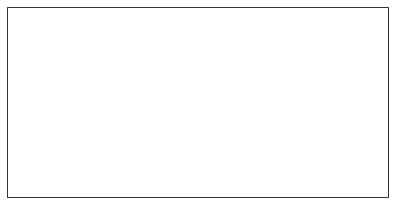

In [10]:
for uid_ind in np.arange(2).astype(str):
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

    params = {
        'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filenames, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': True}

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    tint.visualisation.animate.animate(tracks_obj, grids, params)